In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import torch
import torch.nn as nn
from torch.autograd import Variable

from instructor import Instructor
#from qpnet import QpNet
from qpth.qp import QPFunction


plt.style.use('bmh')

In [2]:
import torch
import torch.nn as nn

class Instructor():
    """ Builds functions for model training, evaluation, saving, loading
     
    evaluate(self, loader): elvauate the loss from loader data 
    """

    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, loader, epoch, run_loss):
        """Trains the model for one epoch.
        Prints the epcoh number for print information
        Returns the ave loss.
        """
        losses = 0.0
        self.model.train()
        for t, (inp, out) in enumerate(loader): 
            self.optimizer.zero_grad()
            out_pre = self.model(inp)
            loss = self.criterion(out_pre, out)
            #loss = self.criterion(out_pre[:,:2], out[:,:2])
            run_loss += loss.data
            losses += loss.data
            if (t+1) % 100 == 0:
                print('[epoch: %d, %5d] training loss: %.3f' %
                      (epoch + 1, t + 1, run_loss / 100))
                run_loss = 0.0
            
            loss.backward()
            self.optimizer.step()        
        return losses/(t+1), run_loss

    
    def evaluate(self, loader):
        """Tests the model, returns the average loss."""
        losses = 0.0

        self.model.eval()
        with torch.no_grad():
            for n, (inp, out) in enumerate(loader):
                out_pre = self.model(inp)
                loss = self.criterion(out_pre, out)
                #loss = self.criterion(out_pre[:,:2], out[:,:2])
                losses += loss.data
        return losses/(n+1)
    
    def save(self,state,dir):
        """ Saves the model in location 'dir'.
        example:
        state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}
        dir = './model_trained/model_name'
        """
        if not os.path.isdir('model_trained'): #save model in a file "model_trainded"
            os.mkdir('model_trained')
        torch.save(state, dir)
        print('--- Save last model state')

    def load(self,dir):
        """ Loads the model in location 'dir', including net parameter, optimer, epoch number.
        Returns the next epoch number
        """
        if not os.path.isdir('model_trained'): #find the file for model saving and loading
            os.mkdir('model_trained')
        checkpoint = torch.load(dir)
        self.model.load_state_dict(checkpoint['net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        print('--- Load last model state')
        print('start epoch:',start_epoch)
        return start_epoch

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from qpth.qp import QPFunction


class QpNet(nn.Module):
    """Builds the strucre of the QPNet.
    
    The struture is input-linear-QP-FC.
    QP means the optimization problem layer over`nz` variables, 
    having `nineq` inequality constraints and `neq` equality 
    constraints.
    The optimization problem is of the form
        \hat z =   argmin_z 1/2*z^T*Q*z + p^T*z
                subject to G*z <= h
                           A*z = b
    where Q \in S^{nz,nz},
        S^{nz,nz} is the set of all positive semi-definite matrices,
        p \in R^{nz}
        G \in R^{nineq,nz}
        h \in R^{nineq}
        A \in R^{neq,nz}
        b \in R^{neq}
        This layer has Q = L*L^T+ϵ*I where L is a lower-triangular matrix,
        and h = G*z0 + s0, b = A*z0 for some learnable z0 and s0,  
        to ensure the problem is always feasible.
    """
    
    def __init__(self, num_input, num_output, num_u=5, eps=1e-4, cuda=True,collect=False):

        """Initiates OptNet."""
        super().__init__()
        self.num_input = num_input
        self.num_output = num_output
        self.num_u = num_u
        self.eps = eps
        self.cuda = cuda
        self.collect = collect
        
        self.N = int(self.num_u/self.num_output)  # get the number of the finite steps in MPC
        self.num_ineq = 2*(num_u + num_input*self.N)
        
        self.Q = Parameter(torch.rand(num_input, num_input),requires_grad=True)
        self.R = Parameter(torch.rand(num_output,num_output),requires_grad=True)
        
        self.A = Parameter(torch.rand(num_input, num_input),requires_grad=True)
        self.B = Parameter(torch.rand(num_input, num_output),requires_grad=True)

        self.s0 = Parameter(10*torch.ones(1,2*num_u),requires_grad=False)
        self.s1 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
        self.s2 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)

        if collect==True:
            self.Q = Parameter(torch.Tensor([[1.0,0.0],[0.0,1.0]]),requires_grad=True)
            self.R = Parameter(torch.eye(num_output),requires_grad=True)
            self.A = Parameter(torch.Tensor([[1.0,1.0],[0,1.0]]),requires_grad=True)
            self.B = Parameter(torch.Tensor([[0.5],[1.0]]),requires_grad=True)
            self.s0 = Parameter(10*torch.ones(1,2*num_u),requires_grad=False)
            self.s1 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
            self.s2 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
                   
        weight = torch.zeros(num_u)
        weight[0] = 1.0
        self.weight = Parameter(weight,requires_grad=False)
            

    def forward(self, x):
        """Builds the forward strucre of the QPNet.
        Sequence: FC-ReLU-(BN)-FC-ReLU-(BN)-QP-Softmax.
        """
        
        A_hat = self.build_A_block()
        B_hat = self.build_B_block()
        
       
        Q = self.Q.mm(self.Q.t())
        R = self.R.mm(self.R.t())
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat, Q_diag = self.build_Q_block(Q, Q, R, B_hat) 
                
        # linear layer  p = 2 * (Q_diag*B_hat)^T * (A_hat*x0)
        num_batch = x.size(0)
        x0 = x.view(num_batch, -1)
        A_x0 = A_hat.mm(x0.t()).t()  # present[x1;x2;...;xN] size: batch * dim(x1;x2;...;xN)
        p = 2*A_x0.mm(Q_diag.mm(B_hat))
        
        G = self.build_G_block(B_hat)
        s0 = self.s0.repeat(num_batch,1)
        s1 = self.s1.repeat(num_batch,1)
        s1 -= A_x0
        s2 = self.s2.repeat(num_batch,1)
        s2 += A_x0
        h = torch.cat((s0,s1,s2),1)
        
        # gets the solution of the basic optimization problem
        e = Variable(torch.Tensor())
        self.Qr = Q_hat
        u_opt = QPFunction(verbose=-1)(Q_hat, p, G, h, e, e)  # size: batch*dim(u)
        # shows solver warning if verbose >= 0
        
        # get the optimal cost
        a = (u_opt.mm(Q_hat)*u_opt/2 + p*u_opt).sum(1)
        b = (A_x0.mm(Q_diag)*A_x0).sum(1)
        c = (x0.mm(Q)*x0).sum(1)

        cost_opt = (a+b+c).unsqueeze(1)  # size: batch*1
        # u0 = u_opt.mv(self.weight).unsqueeze(1)  # only the fisrt action
        cost_and_u = torch.cat((0.1*cost_opt,u_opt),1)
        
        return cost_and_u
    
    def build_A_block(self):
        """
        [A]
        [A^2] 
        [A^3]
        [...]
        """
        N = self.N  # number of MPC steps
        A = self.A
        
        row_list = [A]  # reocrd the every row in B_hat
        
        for i in range(1, N):
            A = A.mm(self.A)
            row_list.append(A)
        return torch.cat(row_list,0)
    
    def build_B_block(self):
        """In MPC, express x vector in u vector and compute the new big B_hat matrix
        [B 0 0 ...
        [AB B 0
        ...
        """

        N = self.N  # number of MPC steps
        row_list = []  # reocrd the every row in B_hat
        
        first_block = self.B
        zero = Variable(torch.zeros(self.num_input, self.num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row= torch.cat([first_block, zero],1)
        row_list.append(row)
        
        for i in range(1, N):
            first_block = self.A.mm(first_block)
            row = torch.cat([first_block, row[:,:self.num_output*(N-1)]],1)
            row_list.append(row)  
            
        return torch.cat(row_list,0)
        
        
    def build_Qdiagnol_block(self, Q, P):
        """ (num_imput*(N-1)) x (num_imput*(N-1))
        The last block is P for x(N)"""
        
        N = self.N  # number of MPC steps
        num_input = self.num_input
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_input, num_input*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, Q, zero],1)  # [0 0 ... Q 0 0 ...]
        for i in range(N, 1, -1):
            row_list.append(row_long[:, (i-1)*num_input : (i+N-1)*num_input])
            
        row = torch.cat([zero, P],1)  # last line by [0 P]
        row_list.append(row)
        
        return torch.cat(row_list,0)
    
    def build_Rdiagnol_block(self, R):
        """
        [R 0 0 ...
        [0 R 0
        ...
        """
        N = self.N  # number of MPC steps
        num_output = self.num_output
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_output, num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, R, zero],1)  # [0 0 ... Q 0 0 ...]
        
        for i in range(N, 0, -1):
            row_list.append(row_long[:, (i-1)*num_output : (i+N-1)*num_output])
        return torch.cat(row_list,0)
        
    def build_Q_block(self, Q, P, R, B_hat):
        """Build the Q_hat matrix so that MPC is tranfered into basic optimization problem
        1/2*Q_hat = B_hat^T * diag(Q) * B_hat + diag(R)
        """
        
        Q_diag = self.build_Qdiagnol_block(Q,P)
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat = B_hat.t().mm(Q_diag.mm(B_hat)) + R_diag
        return 2*Q_hat,Q_diag 
        
        
    def build_G_block(self,B_hat):
        """Build the G matrix so that MPC is tranfered into basic optimization problem
        G = [eye(num_u)]
            [   B_hat  ]
            [-eye(num_u)]
            [  -B_hat  ]
        """
        
        eye = Variable(torch.eye(self.num_u))
        eye = self.vari_gpu(eye)
        G = torch.cat((eye, -eye, B_hat, -B_hat), 0)
        # print(self.B_hat)
        # print(G.size())
        return G
    
    def vari_gpu(self, var):
        if self.cuda:
            var = var.cuda()
            
        return var

# Training

In [4]:
cuda = False

npzfile=np.load('double_integrator_0.1cost.npz') 
x0 = npzfile['x'] 
c_u = npzfile['cost_u'] 
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)

shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)


In [5]:
x = Variable(torch.from_numpy(x0).float(), requires_grad=False)
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False)
if cuda:
    x = x.cuda()
    y = y.cuda()
print("Example, x:", x[100], " |cost_u[0]:",y[100,:])

# split the dataset into train and test
dataset = torch.utils.data.TensorDataset(x,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("train size:",len(train_dataset)," |test size:",len(test_dataset))

# shuffle the data, build dataset batches
batch_size = 80
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

Example, x: tensor([-3.9000, -2.1000])  |cost_u[0]: tensor([ 6.5812,  4.0000, -0.2183, -0.7656, -0.5187, -0.2086])
train size: 5248  |test size: 1313


In [6]:
# Initialize the model.

dim_inp = x0.shape[1]
dim_out = 1
model = QpNet(dim_inp, dim_out,collect=False,cuda=cuda)
device = torch.device("cuda:0" if cuda else "cpu")
model = model.to(device)
loss_fun = torch.nn.MSELoss() # Initialize the loss function

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses_train = []
losses_test = []
instructor = Instructor(model, optimizer, loss_fun)
run_loss = 0.0


In [7]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q.mm(model.Q.t()))
print('R',model.R.mm(model.R.t()))
print('s0',model.s0)
print('s1',model.s1)
print('s2',model.s2)

A Parameter containing:
tensor([[0.8000, 1.2000],
        [0.0000, 0.7000]], requires_grad=True)
B Parameter containing:
tensor([[0.4000],
        [1.1000]], requires_grad=True)
Q tensor([[0.8200, 0.1400],
        [0.1400, 0.9050]], grad_fn=<MmBackward>)
R tensor([[1.2100]], grad_fn=<MmBackward>)
s0 Parameter containing:
tensor([[10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]])
s1 Parameter containing:
tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])
s2 Parameter containing:
tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])


In [8]:
for epoch in range(50):
    loss_train, run_loss = instructor.train(train_loader,epoch,run_loss)
    loss_test = instructor.evaluate(test_loader)
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    print('[epoch: %d] training loss: %.3f, testing loss: %.3f' %
                      (epoch + 1, loss_train, loss_test))

[epoch: 1] training loss: 0.224, testing loss: 0.215


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [38]:
print('A',model.A)
print('B',model.B)
print('Q',model.Q.mm(model.Q.t()))
print('R',model.R.mm(model.R.t()))
print('s0',model.s0)
print('s1',model.s1)
print('s2',model.s2)

A Parameter containing:
tensor([[ 0.9748,  1.1511],
        [-0.2879,  0.9574]], device='cuda:0', requires_grad=True)
B Parameter containing:
tensor([[0.6801],
        [1.9709]], device='cuda:0', requires_grad=True)
Q tensor([[ 1.3049, -0.0725],
        [-0.0725,  1.0077]], device='cuda:0', grad_fn=<MmBackward>)
R tensor([[0.3632]], device='cuda:0', grad_fn=<MmBackward>)
s0 Parameter containing:
tensor([[10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]], device='cuda:0')
s1 Parameter containing:
tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]], device='cuda:0')
s2 Parameter containing:
tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]], device='cuda:0')


(0.0, 0.40514046074822546)

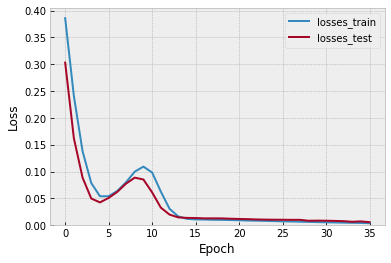

In [28]:
plt.plot(losses_train, label='losses_train')
plt.plot(losses_test, label='losses_test')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0.)

In [39]:
model.eval()
with torch.no_grad():
    for n, (inp, out) in enumerate(test_loader):
        out_pre = model(inp[0,:].unsqueeze(0))
        print('input: ',inp[0,:])
        print('pre: ',out_pre)
        print('true: ',out[0,:])
        print('\n\n\n')


input:  tensor([3.3000, 3.3000], device='cuda:0')
pre:  tensor([[ 8.5358, -3.4742,  2.4718,  0.4850,  0.0907,  0.0097]],
       device='cuda:0')
true:  tensor([ 7.9012, -5.2000,  0.2183,  0.7656,  0.5187,  0.2086], device='cuda:0')




input:  tensor([2.5000, 3.0000], device='cuda:0')
pre:  tensor([[ 5.7438, -2.7793,  1.6208,  0.5985,  0.1356,  0.0226]],
       device='cuda:0')
true:  tensor([ 5.4825, -4.1690, -0.2787,  0.5715,  0.4670,  0.2055], device='cuda:0')




input:  tensor([-1.2000, -2.1000], device='cuda:0')
pre:  tensor([[ 2.0360,  1.8221, -0.9322, -0.3575, -0.0822, -0.0139]],
       device='cuda:0')
true:  tensor([ 2.0444,  2.6795,  0.2537, -0.3114, -0.2729, -0.1235], device='cuda:0')




input:  tensor([-2.3000, -2.2000], device='cuda:0')
pre:  tensor([[ 3.9266,  2.1324, -1.3432, -0.4986, -0.1132, -0.0189]],
       device='cuda:0')
true:  tensor([ 3.6342,  3.2598,  0.1547, -0.4943, -0.3883, -0.1680], device='cuda:0')




input:  tensor([0.5000, 2.4000], device='cuda:0')
pr

In [30]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)
Example, x: tensor([-4., -4.], device='cuda:0')  |cost_u[0]: tensor([13.9479,  8.0000, -2.3726, -1.1463, -0.4071, -0.0817], device='cuda:0')
pre:  torch.Size([6561, 6])


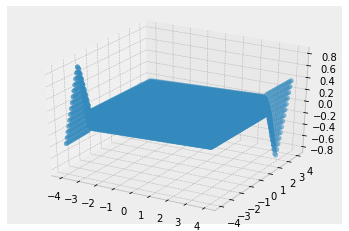

In [31]:


print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
X1 = x0[:,0]
X2 = x0[:,1]
U0 = c_u[:,1]

x = Variable(torch.from_numpy(x0).float(), requires_grad=False).cuda()
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False).cuda()
print("Example, x:", x[0], " |cost_u[0]:",y[0,:])
model.eval()
with torch.no_grad():
    out_pre = model(x)
    print('pre: ',out_pre.size())
U0_pre = out_pre[:,1].cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, U0-U0_pre,cmap=cm.coolwarm)
# ax.scatter(X1, X2,U0_pre )


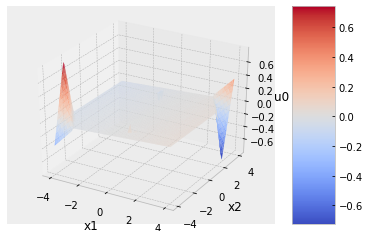

In [32]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X1, X2, U0-U0_pre,cmap=cm.coolwarm )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')
# Customize the z axis.
#ax.set_zlim(-2, 2)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=5)

plt.show()

Text(0.5, 0, 'u0  ')

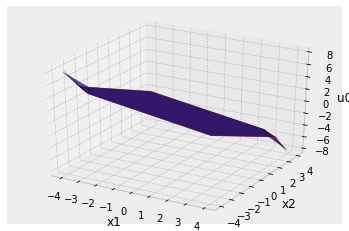

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X1, X2, U0,color="b")
ax.plot_trisurf(X1, X2, U0_pre,color="r" )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')


# Collect MPC data by forward
Because MPC solutions by mpt and opt are different

In [ ]:
# Initialize the model.
dim_inp = 2  # dimension of x
dim_out = 1  # dimension of u
num_u = 5  # N = num_u/dim_out
model = QpNet(dim_inp, dim_out, num_u = 5, cuda=False, collect=True)
model.eval()
list_inp = []
list_out = []
u_max = 10.0
with torch.no_grad():
    for x1 in np.arange(-4.0,4.1,0.1):
        for x2 in np.arange(-4.0,4.1,0.1):
            inp = torch.tensor([x1,x2]).unsqueeze(0)
            out = model(inp)
            if (out[0,1]<=u_max and out[0,1]>=-u_max and
                out[0,2]<=u_max and out[0,2]>=-u_max and
                out[0,3]<=u_max and out[0,3]>=-u_max and
                out[0,4]<=u_max and out[0,4]>=-u_max and
                out[0,5]<=u_max and out[0,5]>=-u_max):
                list_inp.append(inp.numpy())
                list_out.append(out.numpy())
#             print('input: ',inp[0,:])
#             print('pre: ',out)
#             print('\n')

In [ ]:
inp_ = np.array(list_inp).squeeze()
out_ = np.array(list_out).squeeze()
np.savez('double_integrator_0.1cost.npz',x=inp_,cost_u=out_) 